
===== 4.1 CONFIGURACIONES ARTICULARES =====
P1: OK
   q1 = -45.76°
   q2 = 95.76°
   d3 = 75.00 mm

P2: OK
   q1 = -5.58°
   q2 = 58.55°
   d3 = 70.00 mm

P3: OK
   q1 = -77.15°
   q2 = 106.31°
   d3 = 80.00 mm


===== 4.2 GENERANDO TRAYECTORIA CARTESIANA =====
Total de frames generados: 80

===== 4.3 GENERANDO ANIMACIÓN =====


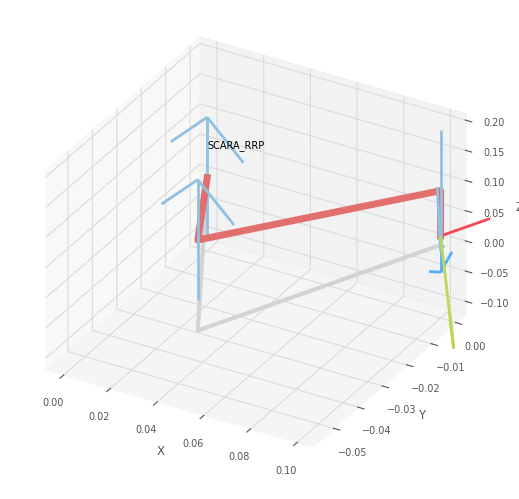

C:\Users\melis\AppData\Local\Temp\ipykernel_16308\3633901485.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(filename))


Frame 80/80

Exportando GIF...
GIF generado correctamente: trayectoria_SCARA.gif
Listo para insertar en tu reporte.


In [7]:
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from spatialmath import SE3
import numpy as np
import imageio
import os

# ============================================================
#   1) Definición del robot SCARA RRP con SERVOS 0-180°
# ============================================================
servo_min = 0 * np.pi/180
servo_max = 180 * np.pi/180

L1 = rtb.RevoluteDH(d=0.15, a=0.077, alpha=0,     qlim=[servo_min, servo_max])
L2 = rtb.RevoluteDH(d=-0.06, a=0.072, alpha=np.pi, qlim=[servo_min, servo_max])
L3 = rtb.PrismaticDH(theta=0, a=0, alpha=0,        qlim=[0, 0.027])

robot = rtb.DHRobot([L1, L2, L3], name="SCARA_RRP")


# ============================================================
#   2) Definición de los tres puntos cartesianos ALCANZABLES
# ============================================================
P1 = SE3(0.10,  0.00, 0.015)   # 10 cm adelante
P2 = SE3(0.12,  0.05, 0.020)   # 12 cm adelante, 5 cm lateral
P3 = SE3(0.08, -0.04, 0.010)   # 8 cm adelante, 4 cm hacia -Y

puntos = [P1, P2, P3]


# ============================================================
#   3) 4.1 — Cálculo de configuraciones articulares (IK)
# ============================================================
print("\n===== 4.1 CONFIGURACIONES ARTICULARES =====")

q_solutions = []
mask = [1, 1, 1, 0, 0, 0]   # Solo posición

for i, P in enumerate(puntos):
    sol = robot.ikine_LM(P, mask=mask)
    if sol.success:
        q = sol.q
        q_solutions.append(q)
        print(f"P{i+1}: OK")
        print(f"   q1 = {np.degrees(q[0]):.2f}°")
        print(f"   q2 = {np.degrees(q[1]):.2f}°")
        print(f"   d3 = {q[2]*1000:.2f} mm\n")
    else:
        print(f"P{i+1}: No se encontró solución.")


# ============================================================
#   4) 4.2 — Trayectoria lineal entre P1 → P2 → P3
# ============================================================
print("\n===== 4.2 GENERANDO TRAYECTORIA CARTESIANA =====")

steps = 40   # pasos por tramo
trayectoria_total = []

# P1→P2
tramo1 = rtb.ctraj(P1, P2, steps)
# P2→P3
tramo2 = rtb.ctraj(P2, P3, steps)

trayectoria_total = list(tramo1) + list(tramo2)
print(f"Total de frames generados: {len(trayectoria_total)}")


# ============================================================
#   5) 4.3 — Animación + exportación a GIF
# ============================================================
print("\n===== 4.3 GENERANDO ANIMACIÓN =====")

output_folder = "frames_scara"
os.makedirs(output_folder, exist_ok=True)

gif_frames = []

# iniciar sim
q_actual = q_solutions[0]    # postura inicial según P1
env = robot.plot(q_actual, backend='pyplot', block=False)
env.ax.set_xlim([-0.1, 0.30])
env.ax.set_ylim([-0.2, 0.20])
env.ax.set_zlim([0.0, 0.25])

for i, T in enumerate(trayectoria_total):

    sol = robot.ikine_LM(T, q0=q_actual, mask=mask)
    
    if sol.success:
        q_actual = sol.q
        robot.q = q_actual
        env.step()

        filename = os.path.join(output_folder, f"f_{i:03d}.png")
        env.fig.savefig(filename)

        # Agrega la imagen al GIF
        gif_frames.append(imageio.imread(filename))

        print(f"Frame {i+1}/{len(trayectoria_total)}", end="\r")

print("\n\nExportando GIF...")

gif_name = "trayectoria_SCARA.gif"
imageio.mimsave(gif_name, gif_frames, duration=0.06)

print(f"GIF generado correctamente: {gif_name}")
print("Listo para insertar en tu reporte.")
plt.close('all')


In [5]:
!pip install imageio